In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from pathlib import Path
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split, KFold
from PIL import Image
from ImageAnalysis import ImageAnalysis
from ImageTableExtraction import ImageTableExtraction
from SudokuDetection import SudokuDetection
from solvers.sudoku.sudoku_solver import SudokuSolver

In [2]:
def perspective_transform(image, conjugates, output_size=640):
    output = np.float32([[0, 0], [output_size - 1, 0], [output_size - 1, output_size - 1], [0, output_size - 1]])
    matrix = cv2.getPerspectiveTransform(conjugates, output)
    return cv2.warpPerspective(image, matrix, (output_size, output_size), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

In [3]:
def to_rgb_from_bgr(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
from imgaug.augmenters.meta import Sequential
import imgaug.augmenters as iaa
import imageio
import torch

def pred_to_conjugates(xmin, ymin, xmax, ymax):
    return np.float32([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])

class SudokuExtractor():
    def __init__(self):
        self.count = 0
        self.model = torch.hub.load('C:/Projects/sudolver-models/data/model/yolov5', 'custom', path='C:/Projects/sudolver-models/data/trained_model/best_2022-04-09.pt', source='local') 

    def preprocess(self, image):
        aug = [iaa.CenterPadToSquare(), iaa.Resize({"height": 640, "width": 640})]
        seq = iaa.Sequential(aug)
        return seq(image=image)
        
    def predict(self, image):
        result = self.model(image)
        if len(result) > 0:
            pred = result.pandas()
            xmin, ymin, xmax, ymax = (int(pred.xyxy[0]['xmin'].values[0]), int(pred.xyxy[0]['ymin'].values[0]), int(pred.xyxy[0]['xmax'].values[0]), int(pred.xyxy[0]['ymax'].values[0]))
            return perspective_transform(image, pred_to_conjugates(xmin, ymin, xmax, ymax))
        else:
            return None

In [50]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.spatial import Delaunay
from imutils import contours as cs
from itertools import product

def apply_clahe(image_gray, clip_limit, tile_size):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
    return clahe.apply(image_gray)

def apply_binary_threshold(image_gray):
    retval, image_binary = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return image_binary

def find_contours(image_binary):
    contours, hierarchy = cv2.findContours(image_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def filter_valid_sudoku_cells(contours, min_cell_area=1000):
    cell_contours = []
    for i in range(len(contours)):
        hull = cv2.convexHull(contours[i])
        if len(contours[i]) < 125 and len(hull) > 3:
            hull_volume = ConvexHull(hull[:,0,:]).volume
            if hull_volume > min_cell_area:
                cell_contours.append(contours[i])
    return cell_contours

def is_valid_sudoku(bounding_boxes):
    valid_boxes = []
    for bounding_box in bounding_boxes:
        width = bounding_box[4]
        valid_width = width >= 40 and width <= 100
        height = bounding_box[5]
        valid_height = height >= 40 and height <= 100
        if valid_width and valid_height:
            valid_boxes.append(bounding_box)
    if len(valid_boxes) == 81:
        return valid_boxes
    else:
        return None

def get_sudoku_bounding_boxes(image_gray):
    clips = [3, 4, 5, 6]
    tiles = [(8,8), (12,12)]
    hyperparameters = product(clips, tiles)
    for (clip, tile) in hyperparameters:
        image_gray = cv2.bilateralFilter(image_gray, 5, 0, 75)
        equalized = apply_clahe(image_gray, clip, tile)
        thresh = apply_binary_threshold(equalized)
        contours = find_contours(thresh)
        cell_contours = filter_valid_sudoku_cells(contours)
        bounding_boxes = sudoku_cell_contours_to_bounding_boxes(cell_contours)
        bounding_boxes = is_valid_sudoku(bounding_boxes)
        if bounding_boxes is not None:
            return (bounding_boxes, thresh)
    return None

def sudoku_cell_contours_to_bounding_boxes(cell_contours):
    # Format of bounding box: (xmin, xmax, ymin, ymax, width, height)
    bounding_boxes = []
    for contour in cell_contours:
        xmin, ymin, width, height = cv2.boundingRect(contour)
        bounding_box = (xmin, ymin, xmin+width, ymin+height, width, height)
        bounding_boxes.append(bounding_box)
    return bounding_boxes

def get_contour_precedence(bounding_box):
    tolerance_factor = 10
    return ((bounding_box[1] // tolerance_factor) * tolerance_factor) * 9 + bounding_box[0]

def sort_bounding_boxes(bounding_boxes):
    sorted_boxes = bounding_boxes.copy()
    sorted_boxes.sort(key = lambda x: get_contour_precedence(x))
    return sorted_boxes

def to_grid(bounding_boxes):
    sorted_boxes = sort_bounding_boxes(bounding_boxes)
    grid = []
    cell_index = 0
    for _ in range(9):
        row = []
        grid.append(row)
        for _ in range(9):
            row.append(sorted_boxes[cell_index])
            cell_index += 1
    return np.array(grid)

In [51]:
def read_samples(folder):
    samples = []
    for file in os.listdir(folder):
        filename = os.fsdecode(file)
        if filename.endswith(".jpg"):
            samples.append(folder + filename)
    return samples

In [45]:
samples = read_samples("C:/Projects/sudolver-models/data/training_data/")
#samples = ["C:/Projects/sudolver-models/data/training_data/2bc851f6-aec5-4e83-a2ba-2b8fe3dfd77b.jpg"]

In [8]:
def laplacian(image, alpha=10):
    normalized = image / 255.0
    laplacian = cv2.Laplacian(normalized, cv2.CV_64F)
    sharp = normalized - alpha * laplacian
    sharp[sharp > 1] = 1
    sharp[sharp < 0] = 0
    sharp = sharp * 255
    sharp = sharp.astype(np.uint8)
    return sharp

In [9]:
import cv2
import os
import sys
import numpy as np
import sklearn
from skimage.feature import hog
from sklearn import svm
from collections import Counter

In [10]:
def read_train_image(fullpath):
    image  = cv2.imread(fullpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)

In [11]:
def load_train_images(folder):
    samples = []
    for file in os.listdir(folder):
        filename = os.fsdecode(file)
        if filename.endswith(".png"):
            fullpath = folder + filename
            image = read_train_image(fullpath)
            samples.append(image)
    return samples

In [12]:
def load_digit_train_set(folder, label):
    images = load_train_images(folder)
    labels = np.repeat(label, len(images))
    print(len(labels))
    return list(zip(images, labels))

In [13]:
def load_digits_train_set():
    entire_set = []
    for digit in range(10):
        digits = []
        if digit == 0:
            digits = load_digit_train_set("C:/Temp/none/", 0)
        else:
            digits = load_digit_train_set(f"C:/Temp/{digit}/", digit)
        entire_set.extend(digits)
    return entire_set

In [14]:
res = load_digits_train_set()

4602
256
291
290
328
300
326
324
262
327


In [15]:
X = [x[0] for x in res]

In [16]:
y = [x[1] for x in res]

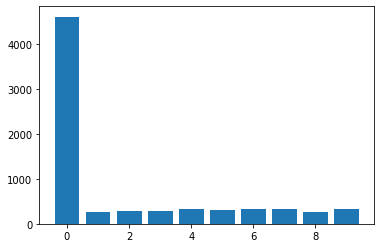

In [17]:
counter = Counter(y)
plt.bar(counter.keys(), counter.values())
plt.show()

In [18]:
from sklearn.utils import resample
majority = [x for x in res if x[1] == 0]
minority = [x for x in res if x[1] > 0]
majority_downsampled = resample(
    majority,
    replace=False,
    n_samples=300,
    random_state=42)

downsampled = majority_downsampled + minority

In [19]:
X = [x[0] for x in downsampled]

In [20]:
y = [x[1] for x in downsampled]

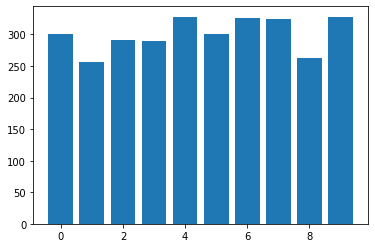

In [21]:
counter = Counter(y)
plt.bar(counter.keys(), counter.values())
plt.show()

In [22]:
def calculate_features_hog(images):
    return np.array([hog(image) for image in images])

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [25]:
features_train = calculate_features_hog(X_train)

In [26]:
classifier = svm.SVC(C=1.0, kernel='rbf', gamma=0.1)
classes = y_train
classifier.fit(features_train, classes)

SVC(gamma=0.1)

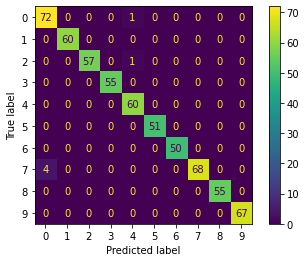

In [27]:
y_pred = classifier.predict(calculate_features_hog(X_test))
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
disp.plot()

In [28]:
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        73
           1       1.00      1.00      1.00        60
           2       1.00      0.98      0.99        58
           3       1.00      1.00      1.00        55
           4       0.97      1.00      0.98        60
           5       1.00      1.00      1.00        51
           6       1.00      1.00      1.00        50
           7       1.00      0.94      0.97        72
           8       1.00      1.00      1.00        55
           9       1.00      1.00      1.00        67

    accuracy                           0.99       601
   macro avg       0.99      0.99      0.99       601
weighted avg       0.99      0.99      0.99       601



In [29]:
%%time
img = read_train_image("C:/Temp/8/digit_8_332.png")
img_features = calculate_features_hog([img])
classifier.predict(img_features)

Wall time: 22 ms


array([8])

In [30]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=200)
neigh.fit(features_train, classes)

KNeighborsClassifier(n_neighbors=200)

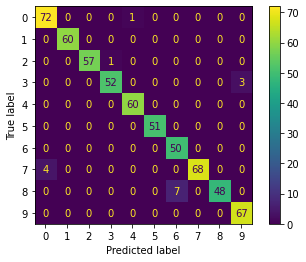

In [31]:
y_pred = neigh.predict(calculate_features_hog(X_test))
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
disp.plot()

In [32]:
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        73
           1       1.00      1.00      1.00        60
           2       1.00      0.98      0.99        58
           3       0.98      0.95      0.96        55
           4       0.98      1.00      0.99        60
           5       1.00      1.00      1.00        51
           6       0.88      1.00      0.93        50
           7       1.00      0.94      0.97        72
           8       1.00      0.87      0.93        55
           9       0.96      1.00      0.98        67

    accuracy                           0.97       601
   macro avg       0.97      0.97      0.97       601
weighted avg       0.98      0.97      0.97       601



In [33]:
from ortools.sat.python import cp_model
from ortools.constraint_solver import pywrapcp

In [52]:
from tqdm import tqdm
from scipy.spatial import Voronoi, voronoi_plot_2d, KDTree
ex = SudokuExtractor()
total = len(samples)
success = 0
failed = []
results = []
#device = "cuda:0" if torch.cuda.is_available() else "cpu"
#processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
#model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed").to(device)
def pred_to_conjugates2(top_left, top_right, bottom_right, bottom_left):
    return np.float32([top_left, top_right, bottom_right, bottom_left])

def find_corner(points):
    corner = None
    corner_dist = 0
    for i in range(len(points)):
        point = points[i]
        dist = np.linalg.norm(np.array([0, 0]) - np.array([point[0], point[1]]))
        if corner is None:
            corner = point
            corner_dist = dist                                        
        elif dist < corner_dist:
            corner = point
            corner_dist = dist
    return corner

def find_uppers(points, n):
    distances = []
    for i in range(len(points)):
        point = points[i]
        dist = np.linalg.norm(np.array([point[0], 0]) - np.array([point[0], point[1]]))
        distances.append(dist)
    mins = np.argsort(distances)
    output = []
    for i in range(n):
        output.append(points[mins[i]])
    return output

def find_lefters(points, n):
    distances = []
    for i in range(len(points)):
        point = points[i]
        dist = np.linalg.norm(np.array([0, point[1]]) - np.array([point[0], point[1]]))
        distances.append(dist)
    mins = np.argsort(distances)
    output = []
    for i in range(n):
        output.append(points[mins[i]])
    return output

def assign_border(board, points, n, row, col):
    corner = find_corner(points)
    uppers = find_uppers(points, n=n)
    lefters = find_lefters(points, n=n)
    board[row][col] = corner
    up_sorted = sorted(uppers, key=lambda p: p[0])
    left_sorted = sorted(lefters, key=lambda p: p[1])
    for i in range(n):
        up = up_sorted[i]
        if up != corner:
            board[row][col + i] = up
            points.remove(up)
    for i in range(n):
        left = left_sorted[i]
        if left != corner:
            board[row+i][col] = left
            points.remove(left)
    points.remove(corner)
    
def assign_board(points):
    board = []
    for i in range(9):
        row = []
        board.append(row)
        for j in range(9):
            row.append(0)
    n = 9
    row = 0
    col = 0
    for cur in range(n-1):
        current_n = n - cur
        assign_border(board, points, current_n, row, col)
        row += 1
        col += 1
    board[8][8] = points[0]
    return board
            
success = 0
solver = SudokuSolver()
total = len(samples)
samples2 = ["C:/Projects/sudolver-models/data/training_data/119f7f07-09cc-4886-bf37-9bf067b5eba5.jpg"]
for sample in tqdm(samples):
    try:
        img = cv2.imread(sample)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img2 = ex.preprocess(img)
        img2 = ex.predict(img2)
        gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
        res = get_sudoku_bounding_boxes(gray)
        if res is not None:
            (bbs, image_binary) = res
            #plt.imshow(image_binary, cmap='gray')
            #break
            points = []
            for bb in bbs:
                x_center = bb[0] + bb[4]
                y_center = bb[1] + bb[5]
                points.append([x_center, y_center, bb])
            board = assign_board(points)
            board_template = []
            i = 0
            for row in board:
                template_row = []
                board_template.append(template_row)
                j = 0
                for cell in row:
                    bb = cell[2]
                    image_patch = image_binary[bb[1]:bb[1]+bb[5]+1, bb[0]:bb[0]+bb[4]+1]
                    conjugates = pred_to_conjugates2(
                        [bb[0], bb[1]],
                        [bb[2], bb[1]],
                        [bb[2], bb[3]],
                        [bb[0], bb[3]])
                    image_persp = perspective_transform(image_binary, conjugates, output_size=64)
                    image_persp = apply_binary_threshold(image_persp)
                    image_features = calculate_features_hog([image_persp])
                    digit = classifier.predict(image_features)[0]
                    if digit == 0:
                        template_row.append("")
                    else:
                        template_row.append(f"{digit}")
                    j += 1
                i += 1
            solved = solver.solve(board_template)
            success += 1
        else:
            pass
    except Exception as exce:
        pass
print(f"performance: {success/total}")

requirements: pandas>=1.1.4 not found and is required by YOLOv5, attempting auto-update...
requirements: Command 'pip install 'pandas>=1.1.4'' returned non-zero exit status 1.
YOLOv5  v6.1-118-g3bb233a torch 1.10.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
100%|███████████████████████████████████████████████████████████████████████████████| 198/198 [06:38<00:00,  2.01s/it]

performance: 0.5656565656565656


In [ ]:
def unsharp_masking(image, k=10, kernel=(5, 5), sigma=3):
    normalized = image / 255.0
    blurred = cv2.GaussianBlur(normalized, kernel, sigma, sigma)
    mask = normalized - blurred
    sharp = normalized + k*mask
    sharp[sharp > 1] = 1
    sharp[sharp < 0] = 0
    sharp = sharp * 255
    sharp = sharp.astype(np.uint8)
    return sharp

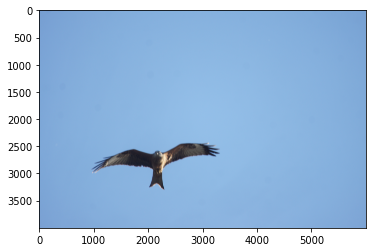

In [37]:
milan = cv2.imread("C:/Temp/Milane/DSC06841.JPG")
milan = cv2.cvtColor(milan, cv2.COLOR_BGR2RGB)
plt.imshow(milan)

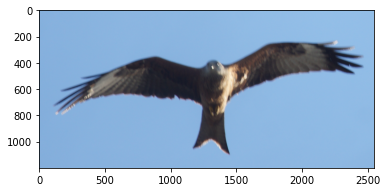

In [43]:
milan_only = milan[2200:3400, 850:3400]
plt.imshow(milan_only)

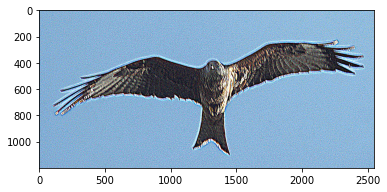

In [54]:
sharp = unsharp_masking(milan_only, k=50, kernel=(9, 9), sigma=10)
plt.imshow(sharp)